# Game 1 DQN

In [ ]:
import random
from pathlib import Path
import numpy as np
import os
os.environ["ARCADE_HEADLESS"] = "true"

import arcade
from arcade.experimental import Shadertoy
from arcade.experimental.lights import Light, LightLayer
import pygame
from pygame import Surface
from collections import namedtuple


# Do the math to figure out our screen dimensions
SCREEN_WIDTH = 800
SCREEN_HEIGHT = 600
SCREEN_TITLE = "Game 1: Let There Be Light!"

SPRITE_SCALING = 0.25

# How fast the camera pans to the player. 1.0 is instant.
CAMERA_SPEED = 0.1

PLAYER_MOVEMENT_SPEED = 7
BOMB_COUNT = 50
TORCH_COUNT = 1
PLAYING_FIELD_WIDTH = 800 #1600
PLAYING_FIELD_HEIGHT = 600 #1600
REWARD_COUNT = 1 #TF - Add in reward
END_GAME = False
torch_collected = False


class LightEnv(arcade.Window):

    def __init__(self, width, height, title):
        super().__init__(width, height, title)
        
        
#         pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
#         self.img = Surface((SCREEN_WIDTH, SCREEN_HEIGHT))

        self.time_before_update = 0
        self.time_after_update = 0

        arcade.Window.headless = True

        self.frame = 0
    
        self.episode_score = 0
        self.score_after_update = 0
        self.score_before_update = 0
        self.done = False
    
        self.camera = None
        
        self.torch_collected = False
        self.time_taken = 0

        # The shader toy and 'channels' we'll be using
        self.shadertoy = None
        self.channel0 = None
        self.channel1 = None
        self.load_shader()

        # Sprites and sprite lists
        self.player_sprite = None
        self.torch = None #TF add 
        self.wall_list = arcade.SpriteList()
        self.player_list = arcade.SpriteList()
        self.bomb_list = arcade.SpriteList() #TF add
        self.reward_list = arcade.SpriteList() #TF add
        self.torch_list = arcade.SpriteList() #TF add
        self.physics_engine = None
        
        self.gui_camera = None #TF added gui camera that can be used to draw gui elements
        self.score = 0 #TF added score
        self.scene = None #TF added scene

        self.generate_sprites()
        
        #TF: Load sounds
        self.collect_bomb_sound = arcade.load_sound(":resources:sounds/explosion2.wav")
        self.collect_reward_sound = arcade.load_sound(":resources:sounds/gameover2.wav")
        arcade.set_background_color(arcade.color.AMARANTH)
        
        #TF Light tutorial
        self.light_layer = None
        # Individual light we move with player, and turn on/off
        self.player_light = None
        LightEnv.center_window(self) #Display game window in center of pc screen


    def load_shader(self):
        # Where is the shader file? Must be specified as a path.
        # shader_file_path = Path("added_light_source-Copy.glsl")
        # shader_file_path = Path("added_light_source.glsl")

        # Size of the window
        window_size = self.get_size()

        # Create the shader toy
        # self.shadertoy = Shadertoy.create_from_file(window_size, shader_file_path)
        self.shadertoy = Shadertoy.create_from_file(window_size, '/content/drive/My Drive/Colab Notebooks/INM363 Project/added_light_source.glsl')

        # Create the channels 0 and 1 frame buffers.
        # Make the buffer the size of the window, with 4 channels (RGBA)
        self.channel0 = self.shadertoy.ctx.framebuffer(
            color_attachments=[self.shadertoy.ctx.texture(window_size, components=4)]
        )
        self.channel1 = self.shadertoy.ctx.framebuffer(
            color_attachments=[self.shadertoy.ctx.texture(window_size, components=4)]
        )

        # Assign the frame buffers to the channels
        self.shadertoy.channel_0 = self.channel0.color_attachments[0]
        self.shadertoy.channel_1 = self.channel1.color_attachments[0]
                
    def generate_sprites(self):
        self.scene = arcade.Scene() # TF initialise scene
        self.camera = arcade.Camera(SCREEN_WIDTH,SCREEN_HEIGHT)
        self.gui_camera = arcade.Camera(self.width, self.height) #TF initialise GUI camera for displaying score
        self.score = 0 #TF keep track of the score
        
        # -- Set up several columns of walls
        for x in range(0, PLAYING_FIELD_WIDTH, 128):
            for y in range(0, PLAYING_FIELD_HEIGHT, int(128 * SPRITE_SCALING)):
                # Randomly skip a box so the player can find a way through
                if random.randrange(2) > 0:
                    wall = arcade.Sprite(":resources:images/tiles/boxCrate_double.png", SPRITE_SCALING)
                    wall.center_x = x
                    wall.center_y = y
                    self.wall_list.append(wall)

        # -- Set some hidden bombs in the area
        for i in range(BOMB_COUNT):
            bomb = arcade.Sprite(":resources:images/tiles/bomb.png", 0.25)
            placed = False
            while not placed:
                bomb.center_x = random.randrange(PLAYING_FIELD_WIDTH)
                bomb.center_y = random.randrange(PLAYING_FIELD_HEIGHT)
                if not arcade.check_for_collision_with_list(bomb, self.wall_list):
                    placed = True
            self.bomb_list.append(bomb)
            self.scene.add_sprite("Bombs", bomb) # TF add bombs to scene

            
        #TF Start - adding in reward sprite
        for i in range(REWARD_COUNT):
            reward = arcade.Sprite(":resources:images/tiles/signExit.png", 0.25)
            placed = False
            while not placed:
                reward.center_x = random.randrange(PLAYING_FIELD_WIDTH)
                reward.center_y = random.randrange(PLAYING_FIELD_HEIGHT)
                if not arcade.check_for_collision_with_list(reward, self.wall_list):
                    placed = True
            self.reward_list.append(reward)
            self.scene.add_sprite("Reward", reward) # add reward to scene
        #TF End - adding in reward sprite
        
        # Create the player
        self.player_sprite = arcade.Sprite(":resources:images/animated_characters/female_person/femalePerson_idle.png",
                                           scale=SPRITE_SCALING)
        self.player_sprite.center_x = 256
        self.player_sprite.center_y = 512
        self.player_list.append(self.player_sprite)
        
        
        
        # Create the torch - TF add
        self.torch = arcade.Sprite(":resources:images/tiles/torch1.png",
                                           scale=SPRITE_SCALING)
        placed = False
        while not placed:
            self.torch.center_x = random.randrange(PLAYING_FIELD_WIDTH)
            self.torch.center_y = random.randrange(PLAYING_FIELD_HEIGHT)
            if not arcade.check_for_collision_with_list(self.torch, self.wall_list):
                placed = True             
        self.torch_list.append(self.torch)
        self.scene.add_sprite("Torch", self.torch) # TF add torch to scene

        # Physics engine, so we don't run into walls
        self.physics_engine = arcade.PhysicsEngineSimple(self.player_sprite, self.wall_list)

    def on_draw(self):

        # Select the channel 0 frame buffer to draw on
        self.channel0.use()
        self.channel0.clear()
        # Draw the walls
        self.wall_list.draw()
        
        self.channel1.use()
        self.channel1.clear()
        # Draw the bombs
        self.bomb_list.draw()
        
        # TF Start - Draw the reward
        self.reward_list.draw()

        # Draw the walls BEFORE light has been calculated - more realistic.
        self.wall_list.draw()
        
        # Select this window to draw on
        self.use()
        # Clear to background color
        self.clear()

        # Run the shader and render to the window
        if self.torch_collected == False:
            self.shadertoy.program['lightPosition'] = self.torch.position #TF add
            self.shadertoy.program['lightSize'] = 50
#             self.shadertoy.program['lightPosition'] = self.player_sprite.position
#             self.shadertoy.program['lightSize'] = 150
            self.shadertoy.render()
        elif self.torch_collected == True:
            self.shadertoy.program['lightPosition'] = self.player_sprite.position #TF add
            self.shadertoy.program['lightSize'] = 500
#             self.shadertoy.program['lightPosition2'] = self.player_sprite.position
#             self.shadertoy.program['lightSize2'] = 500
            self.shadertoy.render()            

        # Draw the walls after light has been calculated
#         self.wall_list.draw()

        self.camera.use()

        #TF Start - Adding camera to display score AFTER light has been calculated
        #Activate the GUI camera before drawing GUI elements
        self.gui_camera.use()

        #Draw our score on the screen, scrolling it with the viewport
        score_text = f"score: {self.score}, time taken: {round(self.time_taken)}"
        arcade.draw_text(
            score_text,
            10,
            10,
            arcade.csscolor.WHITE,
            18,
        )
        #TF End - Adding camera to display score AFTER light has been calculated

        # Draw the player
        self.player_list.draw()
        self.torch_list.draw()
        
        image = arcade.get_image()
#         image.save("test.png")
        
    def on_key_press(self, key, modifiers):
        """Called whenever a key is pressed. """

        if key == arcade.key.UP:
            self.player_sprite.change_y = PLAYER_MOVEMENT_SPEED
        elif key == arcade.key.DOWN:
            self.player_sprite.change_y = -PLAYER_MOVEMENT_SPEED
        elif key == arcade.key.LEFT:
            self.player_sprite.change_x = -PLAYER_MOVEMENT_SPEED
        elif key == arcade.key.RIGHT:
            self.player_sprite.change_x = PLAYER_MOVEMENT_SPEED

    def on_key_release(self, key, modifiers):
        """Called when the user releases a key. """

        if key == arcade.key.UP or key == arcade.key.DOWN:
            self.player_sprite.change_y = 0
        elif key == arcade.key.LEFT or key == arcade.key.RIGHT:
            self.player_sprite.change_x = 0

    def on_update(self, delta_time: float):
        """ Movement and game logic """
        self.score_before_update = self.score
        
        self.time_before_update = self.time_taken_reported() #test
        
        self.time_taken += delta_time

        self.time_after_update = self.time_taken_reported() #test
        
        if self.time_after_update - self.time_before_update == 1:
#             print("-1 time penalty to score")
            self.score -= 1 
        # Call update on all sprites
        
        # Keep the player on screen -TF add from https://realpython.com/arcade-python-game-framework/#drawing-on-the-window
        if self.player_sprite.top > self.height:
            self.player_sprite.top = self.height
        if self.player_sprite.right > self.width:
            self.player_sprite.right = self.width
        if self.player_sprite.bottom < 0:
            self.player_sprite.bottom = 0
        if self.player_sprite.left < 0:
            self.player_sprite.left = 0
        
        self.physics_engine.update()
        
        #TF - Start Testing:
        #See if we hit any bombs
        bomb_hit_list = arcade.check_for_collision_with_list(
            self.player_sprite, self.scene["Bombs"]
        )
        #See if we hit any rewards
        reward_hit_list = arcade.check_for_collision_with_list(
            self.player_sprite, self.scene["Reward"]
        )
        #See if we hit any torches
        torch_hit_list = arcade.check_for_collision_with_list(
            self.player_sprite, self.scene["Torch"]
        )
        
        #Loop through each bomb we hit (if any) and remove it
        for bomb in bomb_hit_list:
            #Remove the bomb
            bomb.remove_from_sprite_lists()
            #Play a sound
            arcade.play_sound(self.collect_bomb_sound)
            #Minus 1 to score
            self.score -= 1
            
#             #Showing image for wrapper testing
#             x = arcade.get_image()
#             x.show()

        #If reward is hit, then remove it and +100 score.
        for reward in reward_hit_list:
            #Remove the reward
            reward.remove_from_sprite_lists()
            #Play a sound
            arcade.play_sound(self.collect_reward_sound)
            #Plus 100 to score
            self.score += 100
            END_GAME = True #TF - Flag for ending game when reward collected
            print(f"Game completed with a score of: {self.score} at time: {round(self.time_taken)}")
            self.done = True
            
        #If torch is hit, then remove it.
        for torch in torch_hit_list:
            #Remove the torch
            self.torch_collected = True
            torch.remove_from_sprite_lists()
            #Play a sound
            arcade.play_sound(self.collect_reward_sound)
            self.physics_engine.update()
            


                        
        #TF attempt to reposition player back to center after bomb collision
        if bomb_hit_list != []:     
            self.player_sprite.center_x = 256 #Might need to paramaterise this to be screen size
            self.player_sprite.center_y = 512 #As resizing window to 80x60 could ruin this
            #Should be ok not to parameterise actually as game calulcated as normal then passed and
            #converted to 80x60 in the wrapper, so it's all scaled.
#         TF - End Testing
     
        self.score_after_update = self.score
#         print("self.score after update: ", self.score_after_update)

        self.frame += 1
        
    def reset(self):
        print("resetting")
        """
        This function resets the environment to its original state (time = 0).
        Then it places the agent at start position and exit at a new random location.
        
        It is common practice to return the observations, 
        so that the agent can decide on the first action right after the resetting of the environment.
        
        """
        
#         arcade.close_window()
#         arcade.set_window()
#         arcade.finish_render()

        self.torch_collected = False
        self.time_taken = 0

        # The shader toy and 'channels' we'll be using
        self.shadertoy = None
        self.channel0 = None
        self.channel1 = None
        self.load_shader()

        # Sprites and sprite lists
        self.player_sprite = None
        self.torch = None #TF add 
        self.wall_list = arcade.SpriteList()
        self.player_list = arcade.SpriteList()
        self.bomb_list = arcade.SpriteList() #TF add
        self.reward_list = arcade.SpriteList() #TF add
        self.torch_list = arcade.SpriteList() #TF add
        self.physics_engine = None
        
        self.gui_camera = None #TF added gui camera that can be used to draw gui elements
        self.score = 0 #TF added score
        self.episode_score = 0 #Reset episode score to 0 at beginning of each episode
        self.scene = None #TF added scene

        self.generate_sprites()
        
        #Get the image object of the current window
        obs = arcade.get_image()
        
        self.done = False #set done flag to false ready for next episode
    
        return obs

    def step(self, action):
        
        #Reset episode score to 0 at beginning of step action
        self.step_score = 0
        
        #Move agent in direction chosen by rllib. (input was 0,1,2,3, changed to up,down,left,right).
        if action == 'up':
            self.player_sprite.change_y = PLAYER_MOVEMENT_SPEED
        elif action == 'down':
            self.player_sprite.change_y = -PLAYER_MOVEMENT_SPEED
        elif action == 'left':
            self.player_sprite.change_x = -PLAYER_MOVEMENT_SPEED
        elif action == 'right':
            self.player_sprite.change_x = PLAYER_MOVEMENT_SPEED
        
        # Calculate the reward for the particular action (0, -1 or +100).
        self.step_score = self.score_after_update - self.score_before_update
#         print(f"score_after_update: {self.score_after_update}, score_before_update: {self.score_before_update}")
        reward = self.step_score #this needs to be old episode score - new episode score
#         print("step in game reward: ", reward)
        obs = arcade.get_image()
        
        return obs, reward, self.done
    
    def stop_movement(self, action):
        print("stopping movement")
        """Called when the player makes a move. """

        if action == 'up' or action == 'down':
            self.player_sprite.change_y = 0
        elif action == 'left' or action == 'right':
            self.player_sprite.change_x = 0
    
    def time_taken_reported(self):
        x = round(self.time_taken)
        return x
    
    


pygame 2.1.2 (SDL 2.0.16, Python 3.7.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
import gym
import random, math
import numpy as np
import arcade
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from PIL import Image

        
# from LightEnvCopy import LightEnv
# from LightEnvCopy import LightEnv

import gym.spaces
from gym.spaces import Discrete, Box

from ray.rllib.env.env_context import EnvContext
from ray.rllib.models import ModelCatalog

from collections import namedtuple

# Do the math to figure out our screen dimensions
SCREEN_WIDTH = 800
SCREEN_HEIGHT = 600
SCREEN_TITLE = "Game 1: Let There Be Light!"

SPRITE_SCALING = 0.25

# How fast the camera pans to the player. 1.0 is instant.
CAMERA_SPEED = 0.1

PLAYER_MOVEMENT_SPEED = 7
BOMB_COUNT = 5
TORCH_COUNT = 1
PLAYING_FIELD_WIDTH = 800 #1600
PLAYING_FIELD_HEIGHT = 600 #1600
REWARD_COUNT = 1 #TF - Add in reward
END_GAME = False
torch_collected = False

#TF Start - Adding in actions for action conversion

# COnvenient data structure to hold information about actions
Action = namedtuple('Action', 'name index delta_i delta_j')

up = Action('up', 0, -1, 0)    
down = Action('down', 1, 1, 0)    
left = Action('left', 2, 0, -1)    
right = Action('right', 3, 0, 1)    

index_to_actions = {}
for action in [up, down, left, right]:
    index_to_actions[action.index] = action
# print(index_to_actions[0].name)
str_to_actions = {}
for action in [up, down, left, right]:
    str_to_actions[action.name] = action
#TF End - Adding in actions for action conversion


class LightEnvWrapper(gym.Env, LightEnv):
    """Class that wraps the Lights Environment to make it 
    compatible with RLLib."""

    metadata = {"render.modes": ["rgb_array", "state_pixels"]}
    
    def __init__(self, config: EnvContext):
        super().__init__(SCREEN_WIDTH, SCREEN_HEIGHT, SCREEN_TITLE)
        self.counting = 0
        game_size = config.get("size_env")

#         self.mygame = GUIWrapper(LightEnv)
        
        self.mygame = LightEnv
        #The action space is a choice of 9 actions: U/D/L/R/UR/DR/DL/UL/DO NOTHING. Not continuous
        #because speed of agent is fixed. Or potentially just 4: U/D/L/R.
        self.action_space = Discrete(4)
        #The observation space is a fixed image of the current game screen - fully observable.
        #Can set to a view just around the player using arcade.set_viewport.
        #Need obs space to be either 42,42,x or 84,84,x to be compatible with rllib.
        self.observation_space = Box(low=0, high=255, shape=(84,84, 4), dtype=np.uint8)
        
        self.counting = 0

    def reset(self):
        print("resetting in wrapper")
        self.render()
        #Resets the state of the environment for a new episode and an initial observation.
        obs_mygame = self.mygame.reset(self)
        
        #Open up the resetted image to verify working correctly.
        obs_mygame.show()
        
        #Convert observation to 84x84 resolution and np array for rllib.
        obs = self.convert_observations(obs_mygame)
        
#         print("resetted")
        return obs

    def step(self, action):
        self.counting += 1
#         print("Wrapper stepping number: ", self.counting) #every 33 is a second in game time.
#         print("stepping")
        #Choose a random action: 0, 1, 2, 3.
        assert action in [0, 1, 2, 3] #0-up,1-down,2-left,3-right.
        
        #Convert the numeric action to a keyword: up, down, left, right.
        actions_myenv = index_to_actions[action].name #returns a word, one of: up/down/left/right
        # print(f"action taken: {actions_myenv}")
        
        #Update the window with on_update()
        self.render()
        
        #Compute observation extracted from the window (800x600), with reward and done flag.
        obs, reward, done = self.mygame.step(self,actions_myenv)
        
        # if self.counting % 33 == 0:
#             print("self.counting is now divisible by 33(ie. 1 second has passed), showing obs now")
            # print(f"total score is {self.score} at time: {self.mygame.time_taken_reported(self)}")
            # obs.show()
            
#         print(f"step reward is {reward}")
        
        #Convert observation to 84x84 resolution and np array for rllib.
        obs_mygame = self.convert_observations(obs)
        
        #If the reward has been obtained, reset the environment and start again
        if done == True:
            print(f"done is {done}, resetting environment in wrapper.")
            obs.save("test.png") 
            self.reset()
        
#         print("Finished stepping")
        return obs_mygame, reward, done, {}

    def seed(self, seed=None):
        random.seed(seed)

    def convert_observations(self, obs_mygame): #Not needed? This is just for rescaling?
        # We normalize and concatenate observations
        obs = obs_mygame
        obs_resized = obs.resize((84,84))
        obsarray = np.array(obs_resized)
#         print("sum: ", np.sum(obsarray))
        return obsarray
    
    def render(self):
        self.mygame.on_update(self, 1/60)
        self.mygame.on_draw(self)
        test = self.mygame.time_taken_reported(self)
#         print("testing time taken: ", test)
        

### Now run the rllib script to train the agent

DQN Wrapper

In [ ]:
# !pip install ray==1.11.0
import gym
import ray.rllib.agents.ppo.ppo as ppo


import ray
import ray.rllib.agents.dqn as dqn
from ray.tune.logger import pretty_print

config = dqn.DEFAULT_CONFIG.copy()
config["preprocessor_pref"] = "rllib"
config["framework"] = "torch"
config["num_gpus"] = 1
config["num_gpus_per_worker"] = 1
config["dueling"] = False
config["double_q"] = False
config["env"] = LightEnvWrapper
# config["env_config"] = { "size_env": 15}
config["model"] = { "fcnet_hiddens": [64, 64],
                    "fcnet_activation": "relu",
    }
print(config)
trainer = dqn.DQNTrainer(config=config)
# Can optionally call trainer.restore(path) to load a checkpoint.

avg_rewards = []
num_iterations = []

for i in range(1000):
    # Perform one iteration of training the policy with PPO
    result = trainer.train()
    #print(pretty_print(result))
    print("episode reward mean: ", result['episode_reward_mean'])
    avg_rewards.append(result['episode_reward_mean'])
    num_iterations.append(i)
    if i % 100 == 0:
        checkpoint = trainer.save()
        print("checkpoint saved at", checkpoint)


2022-09-15 14:05:24,855	WARNING deprecation.py:48 -- DeprecationWarning: `ray.rllib.agents.dqn` has been deprecated. Use `ray.rllib.algorithms.[dqn|simple_q|r2d2|apex_dqn]` instead. This will raise an error in the future!
2022-09-15 14:05:24,882	WARNING deprecation.py:48 -- DeprecationWarning: `ray.rllib.algorithms.dqn.dqn.DEFAULT_CONFIG` has been deprecated. Use `ray.rllib.algorithms.dqn.dqn.DQNConfig(...)` instead. This will raise an error in the future!
2022-09-15 14:05:24,884	WARNING deprecation.py:48 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!
/usr/local/lib/python3.7/dist-packages/ray/_private/ray_option_utils.py:273: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects

{'extra_python_environs_for_driver': {}, 'extra_python_environs_for_worker': {}, 'num_gpus': 1, 'num_cpus_per_worker': 1, 'num_gpus_per_worker': 1, '_fake_gpus': False, 'custom_resources_per_worker': {}, 'placement_strategy': 'PACK', 'eager_tracing': False, 'eager_max_retraces': 20, 'tf_session_args': {'intra_op_parallelism_threads': 2, 'inter_op_parallelism_threads': 2, 'gpu_options': {'allow_growth': True}, 'log_device_placement': False, 'device_count': {'CPU': 1}, 'allow_soft_placement': True}, 'local_tf_session_args': {'intra_op_parallelism_threads': 8, 'inter_op_parallelism_threads': 8}, 'env': <class '__main__.LightEnvWrapper'>, 'env_config': {}, 'observation_space': None, 'action_space': None, 'env_task_fn': None, 'render_env': False, 'clip_rewards': None, 'normalize_actions': True, 'clip_actions': False, 'disable_env_checking': False, 'num_workers': 0, 'num_envs_per_worker': 1, 'sample_collector': <class 'ray.rllib.evaluation.collectors.simple_list_collector.SimpleListCollector

2022-09-15 14:05:27,111	INFO worker.py:1518 -- Started a local Ray instance.
2022-09-15 14:05:29,322	WARNING env.py:143 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.


resetting in wrapper
resetting


2022-09-15 14:05:34,626	WARNING util.py:65 -- Install gputil for GPU system monitoring.


resetting in wrapper
resetting


2022-09-15 14:05:35,271	WARNING deprecation.py:48 -- DeprecationWarning: `ReplayBuffer.add_batch()` has been deprecated. Use `ReplayBuffer.add()` instead. This will raise an error in the future!
2022-09-15 14:05:35,310	WARNING replay_buffer.py:61 -- Estimated max memory usage for replay buffer is 2.82545 GB (50000.0 batches of size 1, 56509 bytes each), available system memory is 13.616361472 GB
2022-09-15 14:05:35,330	WARNING multi_agent_prioritized_replay_buffer.py:221 -- Adding batches with column `weights` to this buffer while providing weights as a call argument to the add method results in the column being overwritten.
Exception ignored in: <function OpenALDriver.__del__ at 0x7f39927ab0e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pyglet/media/drivers/openal/adaptation.py", line 63, in __del__
    self.delete()
  File "/usr/local/lib/python3.7/dist-packages/pyglet/media/drivers/openal/adaptation.py", line 70, in delete
    self.worker.stop(

Game completed with a score of: 98 at time: 2
done is True, resetting environment in wrapper.
resetting in wrapper
resetting
resetting in wrapper
resetting


2022-09-15 14:05:58,075	WARNING deprecation.py:48 -- DeprecationWarning: `concat_samples` has been deprecated. Use `concat_samples() from rllib.policy.sample_batch` instead. This will raise an error in the future!


episode reward mean:  98.0
checkpoint saved at /root/ray_results/DQN_LightEnvWrapper_2022-09-15_14-05-24733puria/checkpoint_000001
episode reward mean:  98.0
episode reward mean:  98.0
episode reward mean:  98.0
episode reward mean:  98.0
episode reward mean:  98.0
episode reward mean:  98.0
episode reward mean:  98.0
episode reward mean:  98.0
episode reward mean:  98.0
episode reward mean:  98.0
episode reward mean:  98.0
episode reward mean:  98.0
episode reward mean:  98.0
episode reward mean:  98.0
episode reward mean:  98.0
episode reward mean:  98.0
episode reward mean:  98.0
Game completed with a score of: -214 at time: 309
done is True, resetting environment in wrapper.
resetting in wrapper
resetting
resetting in wrapper
resetting
episode reward mean:  -58.0
episode reward mean:  -58.0
episode reward mean:  -58.0
episode reward mean:  -58.0
Game completed with a score of: 39 at time: 56
done is True, resetting environment in wrapper.
resetting in wrapper
resetting
resetting in

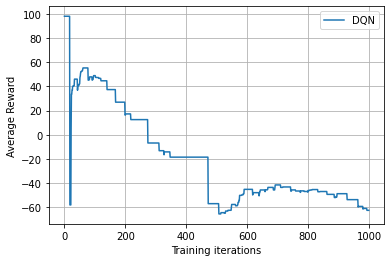

In [ ]:
import matplotlib.pyplot as plt
plt.plot(num_iterations,avg_rewards, label="DQN")
# plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['temp'], label="temporary reward collected")
plt.xlabel("Training iterations")
plt.ylabel("Average Reward")
plt.legend(loc=1)
plt.grid(True)
plt.show()